In [6]:
import netCDF4
import operator
import xarray as xr
import dask
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as patches
from matplotlib import ticker
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import scipy
from scipy import signal
import math

In [7]:
#Good_July.nc
path_to_file = '/fast/gmooers/Real_Geography_Manuscript/Preprocessed_Data/One_Month_July/full_physics_essentials_valid_month02_targets.nc'
real_ds = xr.open_dataset(path_to_file)

path_to_file = '/fast/gmooers/Real_Geography_Manuscript/Models/July_Linear_Baseline.nc'
test_ds = xr.open_dataset(path_to_file)

print('files imported')

files imported


In [8]:
heat_real_ds = real_ds.targets[:, :30].values

heat_test_ds = test_ds.Prediction[:, :30].values

times = real_ds.time.values

lats = real_ds.lat.values

lons = real_ds.lon.values

x = 144
y = 96
z = 30
t = int(len(heat_test_ds)/(x*y))

In [9]:
spacing_x = 1/144
spacing_y = 1/96

reconstructed_targets = np.zeros(shape=(x, y, t, z))
reconstructed_features = np.zeros(shape=(x, y, t, z))
count = 0
for i in range(t):
    for j in range(y):
        for k in range(x):
            #A = targets_heat[count]
            #B = features_heat[count]
            A = heat_real_ds[count]
            B = heat_test_ds[count]
            reconstructed_targets[k, j, i, :] = A
            reconstructed_features[k, j, i, :] = B
            count = count + 1

print(reconstructed_targets.shape)
print(reconstructed_features.shape)

(144, 96, 2975, 30)
(144, 96, 2975, 30)


In [10]:
others = netCDF4.Dataset("/fast/gmooers/Raw_Data/extras/TimestepOutput_Neuralnet_SPCAM_216.cam.h1.2009-01-01-72000.nc")
plev = np.array(others.variables['lev'])
ps = np.array(others.variables['PS'])
g = 9.81 #m/s^2
#print(plev)
hyai = np.array(others.variables['hyai'])
hybi = np.array(others.variables['hybi'])
#print(hyai.shape)
#print(hyai)
cp = 1004.0
L = 2256000.0
PS = 1e5
P0 = 1e5
P = P0*hyai+PS*hybi # Total pressure [Pa]
dp = P[1:]-P[:-1] # Differential pressure [Pa]
#convert from k/s to w/m^2
pressure_weighted_targets = reconstructed_targets*dp[None, None, None, :]*cp/g
pressure_weighted_predictions = reconstructed_features*dp[None, None, None, :]*cp/g

In [11]:
lat_list = lats[::144][:96]
lon_list = lons[:144]
trop_lats = lat_list[37:59]
trop_truths = pressure_weighted_targets[:,37:59,:,:]
trop_predictions = pressure_weighted_predictions[:,37:59,:,:]

In [12]:
#method 1 - Hovmueller Github 
a = 6.37e6 #radius of the earth
dlat = np.abs(lat_list[1]-lat_list[0])
dlon = np.abs(lon_list[0]-lon_list[1])
weights = (dlon*np.pi/180.)*a*np.cos(lat_list*np.pi/180.)
other_weights = np.cos(np.deg2rad(trop_lats))

In [13]:
def weighting(latitudes, R):
    lat_weights = np.empty(shape=(latitudes.size))
    for i in range(len(latitudes)):
        lat_weights[i]= np.sin(np.radians(latitudes[i]))/np.radians(latitudes[i])
    return lat_weights

my_weights = weighting(trop_lats, a)

In [14]:
lon_spaces = np.empty(shape=(trop_lats.size))
for i in range(len(trop_lats)):
    lon_spaces[i] = np.abs((lon_list[1]-lon_list[0])*40075.*np.cos(trop_lats[0])/360.0)*my_weights[i]

lon_spacing = np.nanmean(lon_spaces)/np.nanmean(my_weights)

In [15]:
#lon_spacing = np.abs((lon_list[1]-lon_list[0])*40075.*np.cos(lat_list[0])/360.0)
lat_spacing = 111.32*(lat_list[1]-lat_list[0])

In [16]:
def plotter(target_array, feature_array, frequency, title_name):
    plt.plot(1/frequency, target_array, 'r', alpha = 0.5, label = "Truth")
    plt.plot(1/frequency, feature_array, 'b', alpha=0.5, label = "Prediction")
    plt.legend()
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('Period (Kilometers)')
    h = plt.ylabel(r'$\frac{w^2}{m^4*day}$', fontsize = 15)
    h.set_rotation(0)
    plt.title("Power Spectrum Density for "+title_name)

In [17]:
def spectrum_gen(h, dt):
    nt = len(h)
    #Get half the length of the time series to avoid redudant information
    npositive = nt//2
    pslice = slice(1, npositive)
    #Get frequencies
    freqs = np.fft.fftfreq(nt, d=dt)[pslice] 
    #perform the fft 
    ft = np.fft.fft(h)[pslice]
    #remove imaginary componant of the fft and square
    psraw = np.conjugate(ft) *ft
    #double to account for the negative half that was removed above
    psraw *= 2.0
    #Normalization for the power spectrum
    psraw /= nt**2
    #Go fro mthe Power Spectrum to Power Density
    psdraw = psraw * dt * nt
    return freqs, psraw, psdraw
    
x_temp_freqs, x_temp_psraw, x_temp_psdraw = spectrum_gen(np.squeeze(trop_truths[:,0,0,0]), lon_spacing)
x_temp_freqs, x_temp_sraw, x_temp_psdraw = spectrum_gen(np.squeeze(trop_predictions[:,0,0,0]), lon_spacing)

In [18]:
y_temp_freqs, y_temp_psraw, y_temp_psdraw = spectrum_gen(np.squeeze(trop_truths[0,:,0,0]), lat_spacing)
y_temp_freqs, y_temp_psraw, y_temp_psdraw = spectrum_gen(np.squeeze(trop_predictions[0,:,0,0]), lat_spacing)

In [19]:
np.save('/fast/gmooers/Real_Geography_Manuscript/Data_For_Paper/SPCAM5_X_Spectral_Spacing.npy', x_temp_freqs)
np.save('/fast/gmooers/Real_Geography_Manuscript/Data_For_Paper/SPCAM5_Y_Spectral_Spacing.npy', y_temp_freqs)

In [20]:
1.0/x_temp_freqs[0]

20107.448326561975

(71,)


/export/home/gmooers/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/export/home/gmooers/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


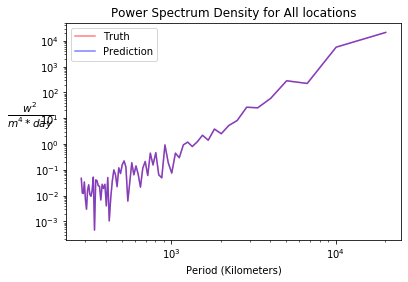

In [21]:
title = 'All locations'
print(x_temp_psdraw.shape)
plotter(x_temp_psdraw, x_temp_psdraw, x_temp_freqs, title)

In [22]:
def spectrum_generator_X(targets, features, levels, latitude_count, longitude_count, time_space):
    time_count = len(targets[0,0,:,0])
    targ_freqs, targ_psraw, targ_psdraw = spectrum_gen(np.squeeze(targets[:,0,0,0]), time_space)
    depth = len(targ_psdraw)
    target_collector = np.zeros(shape=(time_count, latitude_count, levels, depth))
    target_collector[:,:,:] = np.nan
    feature_collector = np.zeros(shape=(time_count, latitude_count, levels, depth))
    feature_collector[:,:,:] = np.nan
    counter = 0
    for i in range(levels):
        print(i)
        for j in range(latitude_count):
            for k in range(time_count):
                target = np.squeeze(targets[:, j, k, i])
                feature = np.squeeze(features[:, j, k, i])
                targ_freqs, targ_psraw, targ_psdraw = spectrum_gen(target, time_space)
                feat_freqs, feat_psraw, feat_psdraw = spectrum_gen(feature, time_space)
                target_collector[k, j, i, :] = targ_psdraw
                feature_collector[k, j, i, :] = feat_psdraw
        
    return targ_freqs, feat_freqs, target_collector, feature_collector 

x_targ_freqs, x_feat_freqs, x_target_collector, x_feature_collector = spectrum_generator_X(trop_truths, trop_predictions, z, trop_lats.size, x, lon_spacing)

0


/export/home/gmooers/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/export/home/gmooers/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [23]:
def spectrum_generator_Y(targets, features, levels, latitude_count, longitude_count, time_space):
    time_count = len(targets[0,0,:,0])
    targ_freqs, targ_psraw, targ_psdraw = spectrum_gen(np.squeeze(targets[0,:,0,0]), time_space)
    depth = len(targ_psdraw)
    target_collector = np.zeros(shape=(time_count, longitude_count, levels, depth))
    target_collector[:,:,:] = np.nan
    feature_collector = np.zeros(shape=(time_count, longitude_count, levels, depth))
    feature_collector[:,:,:] = np.nan
    counter = 0
    for i in range(levels):
        print(i)
        for j in range(longitude_count):
            for k in range(time_count):
                target = np.squeeze(targets[j, :, k, i])
                feature = np.squeeze(features[j, :, k, i])
                targ_freqs, targ_psraw, targ_psdraw = spectrum_gen(target, time_space)
                feat_freqs, feat_psraw, feat_psdraw = spectrum_gen(feature, time_space)
                target_collector[k, j, i, :] = targ_psdraw
                feature_collector[k, j, i, :] = feat_psdraw
        
    return targ_freqs, feat_freqs, target_collector, feature_collector 

#y_targ_freqs, y_feat_freqs, y_target_collector, y_feature_collector = spectrum_generator_Y(pressure_weighted_targets, pressure_weighted_predictions, z, y, x, lat_spacing)

In [24]:
x_target_collector.shape

(2975, 22, 30, 71)

In [25]:
x_lat_weighted_targs = x_target_collector*my_weights[None,:,None,None]/np.nanmean(my_weights)
x_lat_weighted_targs = np.nanmean(x_lat_weighted_targs, axis = 1)

x_lat_weighted_features = x_feature_collector*my_weights[None,:,None,None]/np.nanmean(my_weights)
x_lat_weighted_features = np.nanmean(x_lat_weighted_features, axis = 1)

x_pressure_weighted_target_output = np.nanmean(x_lat_weighted_targs, axis = 1)
x_pressure_weighted_feature_output = np.nanmean(x_lat_weighted_features, axis = 1)

x_target_avg = np.nanmean(x_pressure_weighted_target_output, axis = 0)
x_test_avg = np.nanmean(x_pressure_weighted_feature_output, axis = 0)

In [26]:
#y_lat_weighted_targs = y_target_collector
#y_lat_weighted_targs = np.nanmean(y_lat_weighted_targs, axis = 1)#

#y_lat_weighted_features = y_feature_collector
#y_lat_weighted_features = np.nanmean(y_lat_weighted_features, axis = 1)

#y_pressure_weighted_target_output = np.nanmean(y_lat_weighted_targs, axis = 1)
#y_pressure_weighted_feature_output = np.nanmean(y_lat_weighted_features, axis = 1)

#y_target_avg = np.nanmean(y_pressure_weighted_target_output, axis = 0)
#y_test_avg = np.nanmean(y_pressure_weighted_feature_output, axis = 0)

In [27]:
np.save('/fast/gmooers/Real_Geography_Manuscript/Data_For_Paper/Tropical_Spatial_X_Spectral_Truth_Heat_Linear.npy', x_target_avg)
np.save('/fast/gmooers/Real_Geography_Manuscript/Data_For_Paper/Tropical_Spatial_X_Spectral_Prediction_Heat_Linear.npy', x_test_avg)
np.save('/fast/gmooers/Real_Geography_Manuscript/Data_For_Paper/Tropical_Spatial_X_Spectral_Spacing_Heat_Linear.npy', lon_spacing)


#np.save('/fast/gmooers/Real_Geography_Manuscript/Data_For_Paper/Weighted_Spatial_Y_Spectral_Truth_Heat.npy', y_target_avg)
#np.save('/fast/gmooers/Real_Geography_Manuscript/Data_For_Paper/Weighted_Spatial_Y_Spectral_Prediction_Heat.npy', y_test_avg)
#np.save('/fast/gmooers/Real_Geography_Manuscript/Data_For_Paper/Weighted_Spatial_Y_Spectral_Spacing_Heat.npy', lat_spacing)
